In [1]:
"""
📊 SCRIPT PARA SOBREMUESTREO DE CLASES MINORITARIAS
==============================================================
Duplica y aumenta imágenes en disgust, fear, sad
"""

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import warnings
warnings.filterwarnings('ignore')

print("📊 INICIANDO SOBREMUESTREO...")
print("=" * 80)

# Configuración
PARAMS = {
    'data_path': r'C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive\train',
    'target_count': 1000,  # Imágenes objetivo por clase
    'classes': ['disgust', 'fear', 'sad'],
    'random_state': 42
}

# Configurar generador de aumentación
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# Función para sobremuestrear una clase
def oversample_class(class_name, class_path, target_count):
    print(f"\n🔄 Procesando {class_name}...")
    try:
        images = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        current_count = len(images)
        print(f"📸 Imágenes actuales: {current_count}")
        
        if current_count >= target_count:
            print(f"✅ {class_name} ya tiene suficientes imágenes")
            return
        
        # Calcular cuántas imágenes faltan
        images_needed = target_count - current_count
        print(f"➕ Necesita {images_needed} imágenes adicionales")
        
        # Generar imágenes nuevas
        for i, img_name in enumerate(images):
            if images_needed <= 0:
                break
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(48, 48), color_mode='rgb')
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            
            # Generar imágenes aumentadas
            aug_iter = datagen.flow(x, batch_size=1, save_to_dir=class_path, 
                                  save_prefix=f'aug_{class_name}_{i}', save_format='jpg')
            for _ in range(min(images_needed, 5)):  # Máximo 5 por imagen original
                aug_iter.next()
                images_needed -= 1
        
        # Duplicar imágenes si aún faltan
        if images_needed > 0:
            print(f"🔄 Duplicando imágenes para {class_name}...")
            for i, img_name in enumerate(images):
                if images_needed <= 0:
                    break
                img_path = os.path.join(class_path, img_name)
                img = load_img(img_path)
                for j in range(min(images_needed, 2)):  # Máximo 2 copias por imagen
                    save_img(os.path.join(class_path, f'copy_{i}_{j}_{img_name}'), img)
                    images_needed -= 1
        
        new_count = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f"✅ {class_name} ahora tiene {new_count} imágenes")
    except Exception as e:
        print(f"❌ Error en {class_name}: {e}")

# Ejecutar sobremuestreo
try:
    for class_name in PARAMS['classes']:
        class_path = os.path.join(PARAMS['data_path'], class_name)
        if not os.path.isdir(class_path):
            print(f"❌ Directorio {class_name} no encontrado")
            continue
        oversample_class(class_name, class_path, PARAMS['target_count'])
    print("\n✅ Sobremuestreo completado!")
except Exception as e:
    print(f"❌ Error general: {e}")

print("=" * 80)

📊 INICIANDO SOBREMUESTREO...

🔄 Procesando disgust...
📸 Imágenes actuales: 436
➕ Necesita 564 imágenes adicionales
✅ disgust ahora tiene 1000 imágenes

🔄 Procesando fear...
📸 Imágenes actuales: 4097
✅ fear ya tiene suficientes imágenes

🔄 Procesando sad...
📸 Imágenes actuales: 4830
✅ sad ya tiene suficientes imágenes

✅ Sobremuestreo completado!


In [2]:
"""
🎖️ TRANSFER LEARNING CON MOBILENETV2 Y SOBREMUESTREO
==============================================================
Optimizado para imágenes RGB y clases minoritarias
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

print("🚀 TRANSFER LEARNING CON MOBILENETV2 + SOBREMUESTREO - TARGET 80%+ ACCURACY")
print("=" * 80)


🚀 TRANSFER LEARNING CON MOBILENETV2 + SOBREMUESTREO - TARGET 80%+ ACCURACY


In [3]:
# =============================================================================
# 1. ⚙️ Configuración
# =============================================================================
print("\n🔧 CONFIGURANDO ENTORNO...")
PARAMS = {
    'data_path': r'C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive',
    'img_size': 48,
    'batch_size': 32,
    'epochs': 40,
    'learning_rate': 0.0003,
    'random_state': 42
}

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTIONS)

# Verificar rutas
print("\n🔄 VERIFICANDO RUTAS...")
train_path = os.path.join(PARAMS['data_path'], 'train')
test_path = os.path.join(PARAMS['data_path'], 'test')
try:
    if not os.path.isdir(train_path) or not os.path.isdir(test_path):
        print("❌ Error: Rutas no encontradas o no son directorios")
        exit()
    print("✅ Rutas verificadas")
except Exception as e:
    print(f"❌ Error al verificar rutas: {e}")
    exit()


🔧 CONFIGURANDO ENTORNO...

🔄 VERIFICANDO RUTAS...
✅ Rutas verificadas


In [4]:
# =============================================================================
# 2. 📊 Generadores de Datos
# =============================================================================
print("\n📊 CONFIGURANDO GENERADORES...")
try:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(PARAMS['img_size'], PARAMS['img_size']),
        color_mode='rgb',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=True,
        subset='training',
        seed=PARAMS['random_state']
    )

    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(PARAMS['img_size'], PARAMS['img_size']),
        color_mode='rgb',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=True,
        subset='validation',
        seed=PARAMS['random_state']
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(PARAMS['img_size'], PARAMS['img_size']),
        color_mode='rgb',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=False
    )

    print(f"✅ Entrenamiento: {train_generator.samples} imágenes")
    print(f"✅ Validación: {validation_generator.samples} imágenes")
    print(f"✅ Prueba: {test_generator.samples} imágenes")
except Exception as e:
    print(f"❌ Error en generadores: {e}")
    exit()

# Obtener etiquetas de clases
class_labels = list(train_generator.class_indices.keys())

# Calcular pesos de clase
print("\n⚖️ CALCULANDO PESOS POR CLASE...")
try:
    class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    class_weights_dict = dict(enumerate(class_weights))
    print("📊 Pesos por clase:", {EMOTIONS[i]: f"{w:.3f}" for i, w in class_weights_dict.items()})
except Exception as e:
    print(f"❌ Error al calcular pesos: {e}")
    class_weights_dict = None


📊 CONFIGURANDO GENERADORES...
Found 23419 images belonging to 7 classes.
Found 5854 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Entrenamiento: 23419 imágenes
✅ Validación: 5854 imágenes
✅ Prueba: 7178 imágenes

⚖️ CALCULANDO PESOS POR CLASE...
📊 Pesos por clase: {'angry': '1.047', 'disgust': '4.182', 'fear': '1.021', 'happy': '0.580', 'neutral': '0.842', 'sad': '0.866', 'surprise': '1.319'}


In [5]:
# =============================================================================
# 3. 🏗️ Construcción del Modelo
# =============================================================================
print("\n🏗️ CONSTRUYENDO MOBILENETV2...")
try:
    # Cargar MobileNetV2 preentrenado
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(PARAMS['img_size'], PARAMS['img_size'], 3))
    
    # Congelar todas las capas excepto las últimas 50
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Construir modelo
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    print("✅ Modelo creado")
    model.summary()
except Exception as e:
    print(f"❌ Error al crear modelo: {e}")
    exit()


🏗️ CONSTRUYENDO MOBILENETV2...
✅ Modelo creado
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total pa

In [6]:
# =============================================================================
# 4. 🔧 Compilación del Modelo
# =============================================================================
print("\n🔧 COMPILANDO...")
try:
    model.compile(
        optimizer=Adam(learning_rate=PARAMS['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Modelo compilado")
except Exception as e:
    print(f"❌ Error al compilar: {e}")
    exit()


🔧 COMPILANDO...
✅ Modelo compilado


In [7]:
# =============================================================================
# 5. 📋 Callbacks
# =============================================================================
print("\n📋 CONFIGURANDO CALLBACKS...")
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
]


📋 CONFIGURANDO CALLBACKS...


In [8]:
# =============================================================================
# 6. 🚀 Entrenamiento del Modelo
# =============================================================================
print("\n🚀 INICIANDO ENTRENAMIENTO...")
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=max(1, train_generator.samples // PARAMS['batch_size']),
        epochs=PARAMS['epochs'],
        validation_data=validation_generator,
        validation_steps=max(1, validation_generator.samples // PARAMS['batch_size']),
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=1
    )
    print("\n✅ Entrenamiento completado!")
except Exception as e:
    print(f"❌ Error en entrenamiento: {e}")
    exit()


🚀 INICIANDO ENTRENAMIENTO...
Epoch 1/40
731/731 [==============================] - 114s 149ms/step - loss: 3.4237 - accuracy: 0.2619 - val_loss: 4.2147 - val_accuracy: 0.2797 - lr: 3.0000e-04
Epoch 2/40
731/731 [==============================] - 91s 125ms/step - loss: 2.2837 - accuracy: 0.3627 - val_loss: 2.4350 - val_accuracy: 0.3544 - lr: 3.0000e-04
Epoch 3/40
731/731 [==============================] - 89s 121ms/step - loss: 1.7903 - accuracy: 0.3990 - val_loss: 1.7716 - val_accuracy: 0.4150 - lr: 3.0000e-04
Epoch 4/40
731/731 [==============================] - 90s 123ms/step - loss: 1.5897 - accuracy: 0.4216 - val_loss: 1.7976 - val_accuracy: 0.4083 - lr: 3.0000e-04
Epoch 5/40
731/731 [==============================] - 87s 119ms/step - loss: 1.4974 - accuracy: 0.4371 - val_loss: 1.7509 - val_accuracy: 0.3992 - lr: 3.0000e-04
Epoch 6/40
731/731 [==============================] - 89s 122ms/step - loss: 1.4324 - accuracy: 0.4553 - val_loss: 1.6667 - val_accuracy: 0.4296 - lr: 3.0000e-


📈 GRÁFICAS DE ENTRENAMIENTO...


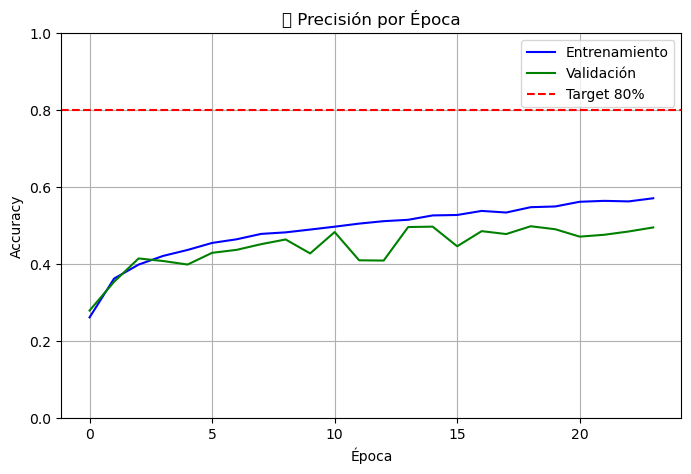

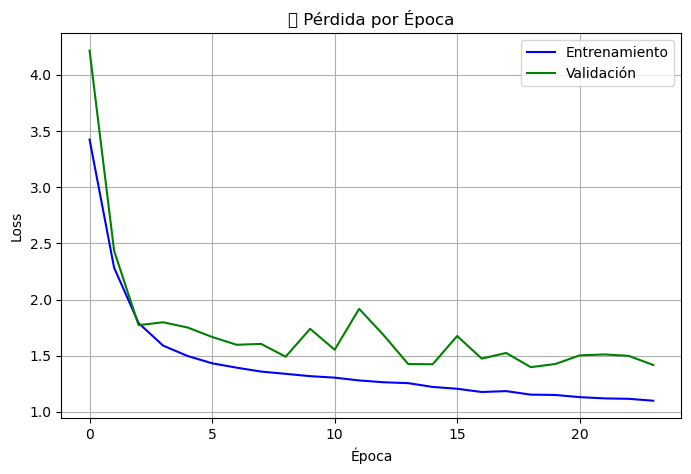


🧪 EVALUANDO MODELO...
224/224 [==============================] - 9s 38ms/step - loss: 1.3145 - accuracy: 0.5276

📊 Test Accuracy: 0.5276, Test Loss: 1.3145
🎯 Target 80%: ❌ NO ALCANZADO
225/225 [==============================] - 8s 29ms/step

🎭 MATRIZ DE CONFUSIÓN...


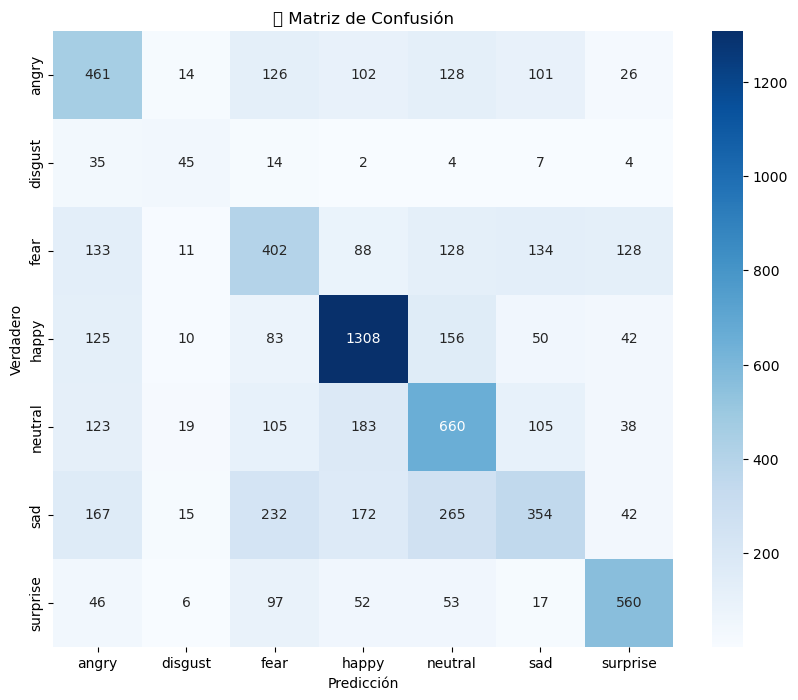


📋 REPORTE DETALLADO...
              precision    recall  f1-score   support

       angry     0.4229    0.4812    0.4502       958
     disgust     0.3750    0.4054    0.3896       111
        fear     0.3796    0.3926    0.3860      1024
       happy     0.6859    0.7373    0.7107      1774
     neutral     0.4735    0.5353    0.5025      1233
         sad     0.4609    0.2839    0.3514      1247
    surprise     0.6667    0.6739    0.6703       831

    accuracy                         0.5280      7178
   macro avg     0.4949    0.5014    0.4944      7178
weighted avg     0.5245    0.5280    0.5218      7178


📊 Weighted F1-Score: 0.5218

📊 GRÁFICA DE PRECISIÓN POR CLASE...


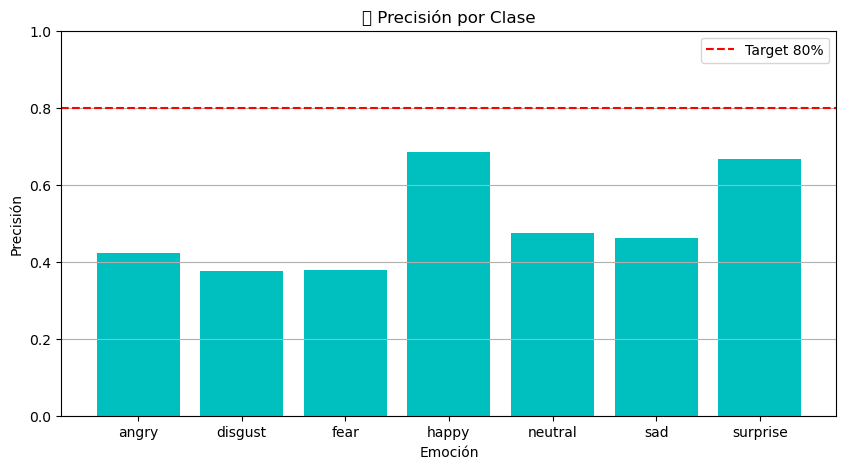


🎯 ANÁLISIS POR CLASE...

angry:
  Verdaderos positivos: 461
  Falsos positivos: 629
  Falsos negativos: 497
  Se confunde con:
    - disgust: 14 veces
    - fear: 126 veces
    - happy: 102 veces
    - neutral: 128 veces
    - sad: 101 veces
    - surprise: 26 veces

disgust:
  Verdaderos positivos: 45
  Falsos positivos: 75
  Falsos negativos: 66
  Se confunde con:
    - angry: 35 veces
    - fear: 14 veces
    - happy: 2 veces
    - neutral: 4 veces
    - sad: 7 veces
    - surprise: 4 veces

fear:
  Verdaderos positivos: 402
  Falsos positivos: 657
  Falsos negativos: 622
  Se confunde con:
    - angry: 133 veces
    - disgust: 11 veces
    - happy: 88 veces
    - neutral: 128 veces
    - sad: 134 veces
    - surprise: 128 veces

happy:
  Verdaderos positivos: 1308
  Falsos positivos: 599
  Falsos negativos: 466
  Se confunde con:
    - angry: 125 veces
    - disgust: 10 veces
    - fear: 83 veces
    - neutral: 156 veces
    - sad: 50 veces
    - surprise: 42 veces

neutral:
  Ver

In [9]:
# =============================================================================
# 7. 📈 Gráficas de Entrenamiento
# =============================================================================
print("\n📈 GRÁFICAS DE ENTRENAMIENTO...")
if 'history' in locals():
    # Gráfica de Precisión
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Entrenamiento', color='b')
    plt.plot(history.history['val_accuracy'], label='Validación', color='g')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target 80%')
    plt.title('🎯 Precisión por Época')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.savefig('mobilenetv2_option2_accuracy_plot.png', dpi=300)
    plt.show()

    # Gráfica de Pérdida
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Entrenamiento', color='b')
    plt.plot(history.history['val_loss'], label='Validación', color='g')
    plt.title('📉 Pérdida por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('mobilenetv2_option2_loss_plot.png', dpi=300)
    plt.show()

# =============================================================================
# 8. 🧪 Evaluación del Modelo
# =============================================================================
print("\n🧪 EVALUANDO MODELO...")
try:
    test_loss, test_accuracy = model.evaluate(test_generator, steps=max(1, test_generator.samples // PARAMS['batch_size']))
    print(f"\n📊 Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
    print(f"🎯 Target 80%: {'✅ ALCANZADO' if test_accuracy >= 0.8 else '❌ NO ALCANZADO'}")
except Exception as e:
    print(f"❌ Error en evaluación: {e}")

# Predicciones
try:
    test_generator.reset()
    y_pred = model.predict(test_generator, steps=max(1, test_generator.samples // PARAMS['batch_size'] + 1))
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes[:len(y_pred_classes)]
except Exception as e:
    print(f"❌ Error en predicciones: {e}")
    exit()

# Matriz de Confusión
print("\n🎭 MATRIZ DE CONFUSIÓN...")
try:
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('🎭 Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.savefig('mobilenetv2_option2_confusion_matrix.png', dpi=300)
    plt.show()
except Exception as e:
    print(f"❌ Error en matriz de confusión: {e}")

# Reporte Detallado
print("\n📋 REPORTE DETALLADO...")
try:
    print(classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4))
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    print(f"\n📊 Weighted F1-Score: {f1:.4f}")
except Exception as e:
    print(f"❌ Error en reporte: {e}")

# Gráfica de Precisión por Clase
print("\n📊 GRÁFICA DE PRECISIÓN POR CLASE...")
try:
    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
    class_accuracies = [report[emotion]['precision'] for emotion in class_labels]
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, class_accuracies, color='c')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target 80%')
    plt.title('🎯 Precisión por Clase')
    plt.xlabel('Emoción')
    plt.ylabel('Precisión')
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.legend()
    plt.savefig('mobilenetv2_option2_class_accuracy_plot.png', dpi=300)
    plt.show()
except Exception as e:
    print(f"❌ Error en gráfica por clase: {e}")

# Análisis de la Matriz de Confusión
print("\n🎯 ANÁLISIS POR CLASE...")
try:
    for i, emotion in enumerate(class_labels):
        true_positives = cm[i, i]
        false_positives = sum(cm[:, i]) - true_positives
        false_negatives = sum(cm[i, :]) - true_positives
        print(f"\n{emotion}:")
        print(f"  Verdaderos positivos: {true_positives}")
        print(f"  Falsos positivos: {false_positives}")
        print(f"  Falsos negativos: {false_negatives}")
        confusions = [(label, cm[i, j]) for j, label in enumerate(class_labels) if j != i and cm[i, j] > 0]
        if confusions:
            print("  Se confunde con:")
            for conf_emotion, count in confusions:
                print(f"    - {conf_emotion}: {count} veces")
except Exception as e:
    print(f"❌ Error en análisis de confusión: {e}")